In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json

from itertools import chain
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

In [2]:
def KL_divergence(dist1, dist2, alpha):
    
    div = 0
    
    for element in dist1.keys():
        if element not in dist2:
            div += dist1[element] * np.log(dist1[element] / alpha)
        else:
            div += dist1[element] * np.log(dist1[element] / dist2[element])
            
    return div

def hellinger_distance(dist1, dist2, n):
    
    num = 0
    
    for element in dist1.keys():
        
        if element not in dist2:
            num += ((dist1[element]) ** (1 / n) - 0) ** n
        else:
            num += ((dist1[element]) ** (1 / n) - (dist2[element]) ** (1 / n)) ** n
        
    num = (1 / np.sqrt(n)) * (num ** (1 / n))
    
    return 1 - num

def get_word_distribution(d, type_ = "train"):
    """
    if train: return word distribution given each class
    if test: return each testing example's word distribution.
    """
    
    from collections import Counter
    from itertools import chain
    
    if type_ == "train":
        ans = Counter(list(d))
        norm = sum(ans.values())
        for element in ans:
            ans[element] /= norm
            
        impute = {}#defaultdict(float)
        for i in ans:
            impute[i] = ans[i]
        return impute

    elif type_ == "test":
        
        ans = []
        for song in d.ID.unique():
            ans1 = Counter(list(d[d.ID == song].word))
            norm = sum(ans1.values())
            for element in ans1:
                ans1[element] /= norm
                
            impute = {}#defaultdict(float)
            for i in ans1:
                impute[i] = ans1[i]
            ans.append(ans1)
        return ans
    
def classify(data, dists, p_genre, n = 2, alpha = 0.1, metric = "hellinger"):
    results = []
    for song in data:
        distance = {}
        for dist in dists:
            if metric == "hellinger":
                distance.update({dist: hellinger_distance(song, dists[dist], n) * p_genre[dist]})
            elif metric == "KL":
                distance.update({dist: KL_divergence(song, dists[dist], alpha)})
                
        if metric == "hellinger":
            results.append(max(distance.items(), key = lambda x: x[1]))
        elif metric == "KL":
            results.append(min(distance.items(), key = lambda x: x[1]))
    return results

## Remove words that don't help us discriminate

In [3]:
df = pd.read_csv("..//..//data//Weekly_data_tokenized.csv")

In [4]:
len(df)

583658

In [5]:
genre = []

for unique in df.ID.unique():
    genre.append(df[df.ID == unique].iloc[0].Genre)
    
genre = [x.split(",") for x in genre]
genre = Counter(list(chain.from_iterable(genre)))
genre = sorted(genre.items(), key = lambda x: x[1], reverse = True)

In [6]:
genre[:10]

[('Pop', 1783),
 ('Rap', 1427),
 ('Rock', 721),
 ('Country', 692),
 ('R&;B', 661),
 ('Trap', 359),
 ('Canada', 266),
 ('Pop-Rock', 207),
 ('Electro-Pop', 204),
 ('Electronic', 197)]

In [7]:
def create_genre(row, genre):
    if re.search(genre, row["Genre"], flags = re.I) != None:
        return 1
    else:
        return 0

In [8]:
df["Pop"] = df.apply(lambda row: create_genre(row, "pop"), axis = 1)
df["Rap"] = df.apply(lambda row: create_genre(row, "rap"), axis = 1)
df["Rock"] = df.apply(lambda row: create_genre(row, "rock"), axis = 1)
df["Country"] = df.apply(lambda row: create_genre(row, "country"), axis = 1)

In [9]:
tmp = df.groupby(["word", "Pop", "Rap", "Rock", "Country"]).count().unstack().unstack().unstack().unstack().fillna(0)["Unnamed: 0"]

In [10]:
def calculate_gini_index(vocabulary):
    index = {}
    
    for word in vocabulary.index:
        index.update({word: sum((vocabulary.loc[word] / vocabulary.loc[word].sum()) ** 2)})
        
    return index

In [11]:
gini = calculate_gini_index(tmp)
useless_words = [x for x in gini if gini[x] <= .2]

In [12]:
with open("..//..//data//gini_indexes.json", "w") as f:
    json.dump(gini, f)

In [13]:
df = df[~df.word.isin(useless_words)]

In [14]:
len(df)

525612

## Create classifier

In [15]:
np.random.seed(1)

IDs = df.ID.unique()
np.random.shuffle(IDs)

train = df[df.ID.isin(IDs[:int(.8 * len(IDs))])]
test = df[df.ID.isin(IDs[int(.8 * len(IDs)):])]

poptrain = train[train["Pop"] == 1].word
raptrain = train[train["Rap"] == 1].word
rocktrain = train[train["Rock"] == 1].word
countrytrain = train[train["Country"] == 1].word

poptest = test[test["Pop"] == 1]
raptest = test[test["Rap"] == 1]
rocktest = test[test["Rock"] == 1]
countrytest = test[test["Country"] == 1]

poptraindist = get_word_distribution(poptrain)
raptraindist = get_word_distribution(raptrain)
rocktraindist = get_word_distribution(rocktrain)
countrytraindist = get_word_distribution(countrytrain)

dists = {"pop": poptraindist, "rap": raptraindist, "rock": rocktraindist, "country": countrytraindist}

poptestdist = get_word_distribution(poptest, "test")
raptestdist = get_word_distribution(raptest, "test")
rocktestdist = get_word_distribution(rocktest, "test")
countrytestdist = get_word_distribution(countrytest, "test")

numpop = len(train[train.Pop == 1].ID.unique())
numrap = len(train[train.Rap == 1].ID.unique())
numrock = len(train[train.Rock == 1].ID.unique())
numcountry = len(train[train.Country == 1].ID.unique())
popprop = numpop / (numpop + numrap + numrock + numcountry)
rapprop = numrap / (numpop + numrap + numrock + numcountry)
rockprop = numrock / (numpop + numrap + numrock + numcountry)
countryprop = numcountry / (numpop + numrap + numrock + numcountry)
p_genre = {"pop": popprop, "rap": rapprop, "rock": rockprop, "country": countryprop}

## KL grid search

In [16]:
def setup(p_genre, n, metric):
    
    if metric == "KL":
    
        pops = [x[0] for x in classify(poptestdist, dists, p_genre, alpha = float(n), metric = metric)]
        raps = [x[0] for x in classify(raptestdist, dists, p_genre, alpha = float(n), metric = metric)]
        rocks = [x[0] for x in classify(rocktestdist, dists, p_genre, alpha = float(n), metric = metric)]
        countrys = [x[0] for x in classify(countrytestdist, dists, p_genre, alpha = float(n), metric = metric)]
    elif metric == "hellinger":
        pops = [x[0] for x in classify(poptestdist, dists, p_genre, n = float(n), metric = metric)]
        raps = [x[0] for x in classify(raptestdist, dists, p_genre, n = float(n), metric = metric)]
        rocks = [x[0] for x in classify(rocktestdist, dists, p_genre, n = float(n), metric = metric)]
        countrys = [x[0] for x in classify(countrytestdist, dists, p_genre, n = float(n), metric = metric)]
    
    predicted = pops + raps + rocks + countrys
    true = ["pop" for _ in range(len(pops))] + ["rap" for _ in range(len(raps))] + ["rock" for _ in range(len(rocks))] +\
            ["country" for _ in range(len(countrys))]
    
    return confusion_matrix(predicted, true)

In [91]:
grid = {}

for n in np.linspace(0.0000000001, 0.0001, 2000):
    confmat = setup(p_genre, n, "KL")
    grid.update({n: confmat})

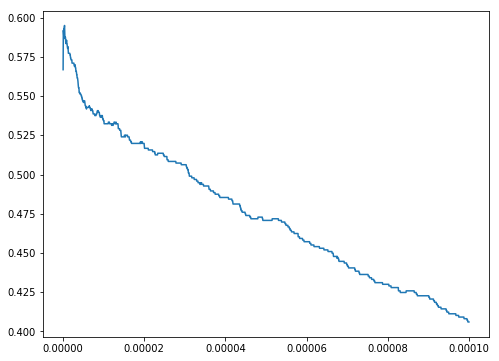

In [92]:
plt.figure(figsize = (8, 6))
plt.plot([i for i in grid], [np.diag(grid[i]).sum() / grid[i].sum() for i in grid])
plt.savefig("..//..//visualizations//multigenre_KL.png", dpi = 200)

## Hellinger grid search

### With $P(genre)$

In [19]:
grid = {}

for n in np.linspace(0, 5, 2000)[1:]:
    
    confmat = setup(p_genre, n, "hellinger")
    grid.update({n: confmat})

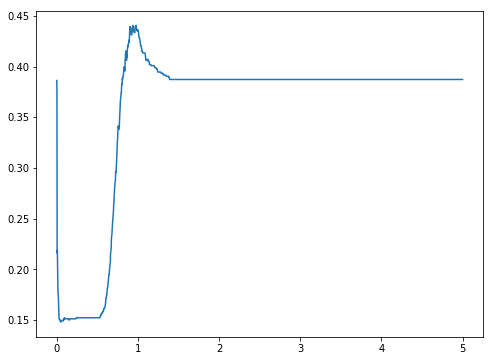

In [20]:
plt.figure(figsize = (8, 6))
plt.plot([i for i in grid], [np.diag(grid[i]).sum() / grid[i].sum() for i in grid])
plt.savefig("..//..//visualizations//multigenre_hellinger_with_prob.png", dpi = 200)

### Without $P(genre)$

In [21]:
grid = {}
no = {"pop": 0.25, "rap": 0.25, "rock": 0.25, "country": 0.25}

for n in np.linspace(0, 10, 2000)[1:]:
    confmat = setup(no, n, "hellinger")
    grid.update({n: confmat})

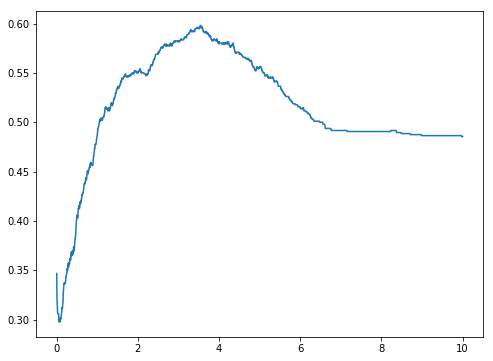

In [22]:
plt.figure(figsize = (8, 6))
plt.plot([i for i in grid], [np.diag(grid[i]).sum() / grid[i].sum() for i in grid])
plt.savefig("..//..//visualizations//multigenre_hellinger_without_prob.png", dpi = 200)

In [80]:
pops = [x[0] for x in classify(poptestdist, dists, no, n = 3.5, metric = "hellinger")]
raps = [x[0] for x in classify(raptestdist, dists, no, n = 3.5, metric = "hellinger")]
rocks = [x[0] for x in classify(rocktestdist, dists, no, n = 3.5, metric = "hellinger")]
countrys = [x[0] for x in classify(countrytestdist, dists, no, n = 3.5, metric = "hellinger")]
predicted = pops + raps + rocks + countrys
true = ["pop" for _ in range(len(pops))] + ["rap" for _ in range(len(raps))] + ["rock" for _ in range(len(rocks))] +\
        ["country" for _ in range(len(countrys))]

In [81]:
confmat = confusion_matrix(predicted, true)
confmat

array([[ 94,  33,   3,  51],
       [ 26, 194,  39,  55],
       [  2,  66, 232,   6],
       [ 24,  78,   5,  50]], dtype=int64)

### Pop class percentage

In [82]:
p_genre['pop']

0.3847160429207014

In [83]:
np.diag(confmat).sum() / confmat.sum()

0.5949895615866388

1. Do a write-up
2. Account for multiple genres within a song
3. dimension reduction



- Account for multiple genres
- Narrow down the dimensions
 - reduce on the most important words
   - gini coefficient
 - reduce w/ linear algebra technique
   - LDA
- try different metrics 
 - KL divergence
- don't want to lean on infrequent words too much

Naive bayes accuracy is NOT 57.21%. Let Bodwin know what you did wrong.

# Naive Bayes comparison

In [26]:
def build_vocabulary(df, vocab = {}):
    """
    df: dataframe of tidy data to build vocab
    """
    index = len(vocab)

    for document in df.ID.unique():
        words = df[df.ID == document].word
        for word in words:
            if word not in vocab:
                vocab.update({word: index})
                index += 1
    return vocab


def build_word_vector(vocab, document):
    """
    vocab: dictionary with key = word, value = index of list to populate
    document: document to build a word vector from
    returns: a word vector with 0 = word not present, 1 = word present
    """
    vec = np.zeros(len(vocab))
    words = document.word
    for word in words:
        if word in vocab:
            vec[vocab[word]] += 1
    return vec

In [27]:
train_words = train[["ID", "word"]]
test_words = test[["ID", "word"]]

vocab = build_vocabulary(train_words)
vocab = build_vocabulary(test_words, vocab)

In [28]:
X_train, y_train, X_test, y_test = [], [], [], []

poptrain = train[train["Pop"] == 1]
raptrain = train[train["Rap"] == 1]
rocktrain = train[train["Rock"] == 1]
countrytrain = train[train["Country"] == 1]

poptest = test[test["Pop"] == 1]
raptest = test[test["Rap"] == 1]
rocktest = test[test["Rock"] == 1]
countrytest = test[test["Country"] == 1]

# build training set

for doc in poptrain.ID.unique():
    tmp = poptrain[poptrain.ID == doc]
    X_train.append(build_word_vector(vocab, tmp))
    y_train.append("pop")
    
for doc in raptrain.ID.unique():
    tmp = raptrain[raptrain.ID == doc]
    X_train.append(build_word_vector(vocab, tmp))
    y_train.append("rap")  
    
for doc in rocktrain.ID.unique():
    tmp = rocktrain[rocktrain.ID == doc]
    X_train.append(build_word_vector(vocab, tmp))
    y_train.append("rock")
    
for doc in countrytrain.ID.unique():
    tmp = countrytrain[countrytrain.ID == doc]
    X_train.append(build_word_vector(vocab, tmp))
    y_train.append("country")  
    
# build testing set
    
for doc in poptest.ID.unique():
    tmp = poptest[poptest.ID == doc]
    X_test.append(build_word_vector(vocab, tmp))
    y_test.append("pop")
    
for doc in raptest.ID.unique():
    tmp = raptest[raptest.ID == doc]
    X_test.append(build_word_vector(vocab, tmp))
    y_test.append("rap")
    
for doc in rocktest.ID.unique():
    tmp = rocktest[rocktest.ID == doc]
    X_test.append(build_word_vector(vocab, tmp))
    y_test.append("rock")
    
for doc in countrytest.ID.unique():
    tmp = countrytest[countrytest.ID == doc]
    X_test.append(build_word_vector(vocab, tmp))
    y_test.append("country")

## Grid searching bernoulli NB

In [29]:
grid = {}

for n in np.linspace(0, 2, 2000)[1:]:
    clf = BernoulliNB(alpha = n)
    clf.fit(X_train, y_train)
    grid.update({n: confusion_matrix(clf.predict(X_test), y_test)})

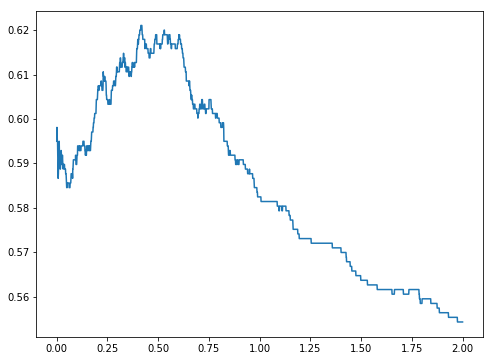

In [30]:
plt.figure(figsize = (8, 6))
plt.plot([i for i in grid], [np.diag(grid[i]).sum() / grid[i].sum() for i in grid])
plt.savefig("..//..//visualizations//multigenre_bernoulliNB.png", dpi = 200)

In [31]:
clf = BernoulliNB(alpha = 0.5)
clf.fit(X_train, y_train)
confmat = confusion_matrix(clf.predict(X_test), y_test)
np.diag(confmat).sum() / confmat.sum()

0.6169102296450939

## Grid searching multinomial NB

In [32]:
grid = {}

for n in np.linspace(0, 5, 2000)[1:]:
    clf = MultinomialNB(alpha = n)
    clf.fit(X_train, y_train)
    grid.update({n: confusion_matrix(clf.predict(X_test), y_test)})

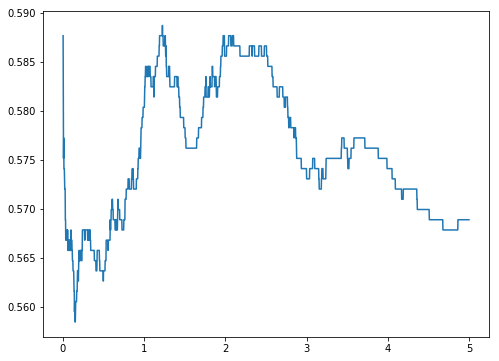

In [33]:
plt.figure(figsize = (8, 6))
plt.plot([i for i in grid], [np.diag(grid[i]).sum() / grid[i].sum() for i in grid])
plt.savefig("..//..//visualizations//multigenre_multinomialNB.png", dpi = 200)

In [34]:
clf = MultinomialNB(alpha = 0.45)
clf.fit(X_train, y_train)
confmat = confusion_matrix(clf.predict(X_test), y_test)
np.diag(confmat).sum() / confmat.sum()

0.5647181628392485